In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch as torch 
import torch.nn as nn
import torch.optim as optim
import dataset_utils
import torch.nn.functional as F
import torchvision.models as models
from pytorch_metric_learning import distances, losses, miners, reducers

In [2]:

def binarize_hard(x):
    return torch.where(x > 0, 1.0, -1.0)

In [3]:
# Reference code
class BinaryModel(nn.Module):
    def __init__(self, dim, D, num_classes, enc_type='RP', binary=True, device='cpu', kargs=None):
        super(BinaryModel, self).__init__()
        self.enc_type, self.binary = enc_type, binary	
        self.device = device
        if enc_type in ['RP', 'RP-COS']:
            self.rp_layer = nn.Linear(dim, D).to(device)
            self.class_hvs = torch.zeros(num_classes, D).float().to(device)
            self.class_hvs_nb = torch.zeros(num_classes, D).float().to(device)
        else:
            pass
    #hard sigmoid    
    def weight_binarize(self, W):
       W = torch.where(W<-1,-1,W)
       W = torch.where(W>1,1,W)
       mask1 = (W >= -1) & (W < 0)
       W[mask1] = 2 * W[mask1] + W[mask1]*W[mask1]
       mask2 = (W >= 0) & (W < 1)
       W[mask2] = 2 * W[mask2] - W[mask2]*W[mask2]
       # W[W > 1] = 1
       return W
    #using Bi-Real Approximation     
    def activation_binarize(self,a):
       a = torch.where(a<-1,-1,a)
       a = torch.where(a>1,1,a)
       mask1 = (a >= -1) & (a < 0)
       a[mask1] = 2 * a[mask1] + a[mask1]*a[mask1]
       #a[mask1] = 0
       mask2 = (a >= 0) & (a < 1)
       a[mask2] = 2 * a[mask2] - a[mask2]*a[mask2]
       #a = torch.where((a >= -1) & (a < 0),2*a + torch.pow(a,2) )
       #a = torch.where((a >= 0) & (a < 1), 2*a- torch.pow(a,2))
    #    a [a < -1] = -1
    #    a [a > 1]   =  1
    #    a [(a >= -1) & (a < 0)] = 2*a[(a >= -1) & (a < 0)] + torch.pow(a [(a >= -1) & (a < 0)],2)
    #    a [(a >= 0) & (a < 1)] = 2*a[(a >= 0) & (a < 1)] - torch.pow(a [(a >= 0) & (a < 1)],2)
       return a

    def encoding(self, x):
        if self.enc_type == 'RP':
            #x = self.activation_binarize(x) 
            #need not binarize the inputs 
            #progressively binarize the inputs, after training the weights
            #add some print statements and check 
            #print("The value of weights, before binarization")
            #print(self.rp_layer.weight.data)
            weights = self.rp_layer.weight.data.clone()
            weights_bin = self.weight_binarize(weights)
            self.rp_layer.weight.data = weights_bin.clone() 
            out = self.rp_layer(x)
            #print("The value of weights, after binarization")
            #print(self.rp_layer.weight.data)
        else:
                pass
        
        return self.activation_binarize(out) if self.binary else out
    
    #Forward Function
    def forward(self, x, embedding=False):
        out = self.encoding(x)
        if embedding:
            out = out
        else:
            out = self.similarity(class_hvs=binarize_hard(self.class_hvs), enc_hv=out)   
        return out
    
    def init_class(self, x_train, labels_train):
        out = self.encoding(x_train)
        if self.binary:
            out = binarize_hard(out)

        for i in range(x_train.size()[0]):
            self.class_hvs[labels_train[i]] += out[i]
        
        if self.binary:
            self.class_hvs = binarize_hard(self.class_hvs)


        
    def HD_train_step(self, x_train, y_train, lr=1.0):
        shuffle_idx = torch.randperm(x_train.size()[0])
        x_train = x_train[shuffle_idx]
        train_labels = y_train[shuffle_idx]
        l= list(self.rp_layer.parameters())
        enc_hvs = binarize_hard(self.encoding(x_train))
        for i in range(enc_hvs.size()[0]):
            sims = self.similarity(self.class_hvs, enc_hvs[i].unsqueeze(dim=0))
            predict = torch.argmax(sims, dim=1)
            
            if predict != train_labels[i]:
                self.class_hvs_nb[predict] -= lr * enc_hvs[i]
                self.class_hvs_nb[train_labels[i]] += lr * enc_hvs[i]
            
            self.class_hvs.data = binarize_hard(self.class_hvs_nb)
    
    def similarity(self, class_hvs, enc_hv):
	    return torch.matmul(enc_hv, class_hvs.t())/class_hvs.size()[1]
    
    

In [4]:
nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset('mnist', 256, "cpu")


In [5]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
num_samples = 500
train_loader_truncated = Subset(train_loader.dataset, range(num_samples))
train_loader_truncated = DataLoader(train_loader_truncated, batch_size=256, shuffle=True)


In [6]:
D = 1000


In [7]:

model = BinaryModel(dim = nFeatures, D=D, num_classes=nClasses, enc_type='RP', device="cpu")


In [8]:

model.init_class( x_train=x_train, labels_train=y_train)

In [23]:
lr = 0.0001


In [10]:

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=-1,high=1)
#distance = distances.LpDistance(normalize_embeddings=True, p=2, power=1)
#reducer = reducers.MeanReducer()

In [24]:

def HD_test(model, x_test, y_test):
    #out = model(x_test, embedding=False)
	out = model(x_test)
	preds = torch.argmax(out, dim=-1)
	acc = torch.mean((preds==y_test).float())	
	return acc

def get_Hamming_margin(model, x_test, y_test=None):
	def Hamming_distance(a, b):
		D = a.size()[1]
		return (D - a @ b.T)/2

	# Compute mean Hamming distance between class HVS
	class_hvs = binarize_hard(model.class_hvs.data)
	class_Hamming_distance = Hamming_distance(class_hvs, class_hvs)
	mean_class_Hamming_distance = torch.mean(class_Hamming_distance).item()
	

	# Compute test samples' Hamming distance
	test_enc_hvs = binarize_hard(model(x_test, True)) 
	test_Hamming_dist = Hamming_distance(test_enc_hvs, class_hvs)

	sorted_test_Hamming_distance, _ = torch.sort(test_Hamming_dist, dim=-1, descending=False)
	test_enc_hvs_Hamming_margin = (sorted_test_Hamming_distance[:,1:]-sorted_test_Hamming_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cpu()
	mean_test_Hamming_margin = torch.mean(test_enc_hvs_Hamming_margin).item()

	res_dict = {
		"avg_class_Hamming_dist": mean_class_Hamming_distance,
		"avg_test_Hamming_margin": mean_test_Hamming_margin
	}
	return mean_test_Hamming_margin

In [25]:
num_metric_epochs = 4
device = "cpu"
accuracies = []
accuracies.append(HD_test(model, x_test, y_test).item())
margins = []
margins.append(get_Hamming_margin(model, x_test, y_test))

In [26]:

loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)


In [27]:

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0) 


In [28]:

model.class_hvs = nn.parameter.Parameter(data=model.class_hvs)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard", )

In [29]:
def metric_train(model, mining_func, device, train_loader, optimizer, epoch,segment_length, zeroes):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data.reshape(data.size()[0],-1))
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings,labels,indices_tuple)
        loss.backward()
        optimizer.step()
    

In [30]:
### pytorch-metric-learning using Triplet margin loss ###
print("Triplet Loss")
for epoch_i in range(1, num_metric_epochs + 1):
    metric_train(model, mining_func, device, train_loader, optimizer, epoch_i,segment_length=50, zeroes=25)
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins.append(get_Hamming_margin(model, x_test, y_test))
    print("Epoch",epoch_i)
    print("Accuracy",accuracies[epoch_i])


Triplet Loss
Epoch 1
Accuracy 0.8830999732017517
Epoch 2
Accuracy 0.8831999897956848
Epoch 3
Accuracy 0.8830000162124634
Epoch 4
Accuracy 0.8830000162124634


In [31]:
num_HD_epoch = 20
HD_lr = 1
class_accuracies = []
class_margins = []
for epoch_i in range(1, num_HD_epoch+1):
    model.HD_train_step(x_train, y_train, lr=HD_lr)
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins.append(get_Hamming_margin(model, x_test, y_test))
    print("Epoch",epoch_i)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


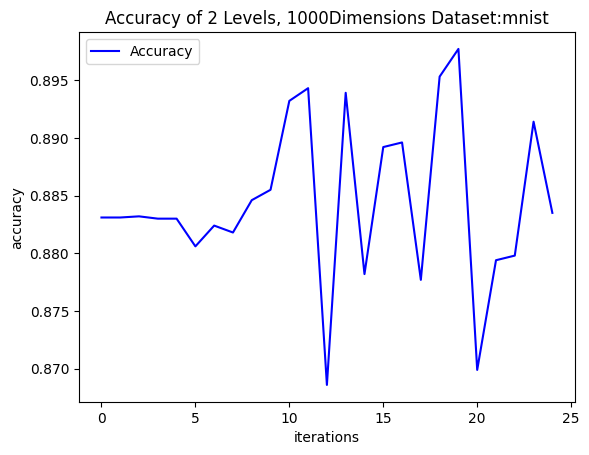

Maximum Accuracy:0.8977000117301941


In [32]:
plt.plot(accuracies, label="Accuracy", c = "blue")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.title(f"Accuracy of 2 Levels, "+ str(D) + "Dimensions Dataset:mnist")
plt.legend()
plt.show()
print("Maximum Accuracy:{}".format(max(accuracies)))

In [ ]:
from gkpd import gkpd
from gkpd.tensorops import kron
from gkpd.tensorops import multidimensional_slice

In [ ]:

class KroneckerDecomposition_new(nn.Module):
    def __init__(self, A, B, C, dim, D, num_classes):
        super(KroneckerDecomposition_new, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor(A))
        self.B = torch.nn.Parameter(torch.tensor(B))
        self.C = torch.nn.Parameter(torch.tensor(C))
        self.class_hvs = torch.zeros(num_classes, D).float().to(device)
        self.class_hvs_nb = torch.zeros(num_classes, D).float().to(device)

    def weight_binarize(self, W):
       W = torch.where(W<-1,-1,W)
       W = torch.where(W>1,1,W)
       mask1 = (W >= -1) & (W < 0)
       W[mask1] = 2 * W[mask1] + W[mask1]*W[mask1]
       mask2 = (W >= 0) & (W < 1)
       W[mask2] = 2 * W[mask2] - W[mask2]*W[mask2]
       W = W.float()
       return W
        
    def forward(self,x, embedding=False):
        out = self.encoding(x)
        if embedding:
            out = out
        else:
            out = self.similarity(class_hvs=binarize_hard(self.class_hvs), enc_hv=out)   
        return out
    
    def encoding(self,x):
        #print("Entering Encoding")
        #Comment
        #Can try to run without binarizing also 
        #Comment
        # the next two lines can be commented
        #bin_A = self.weight_binarize(self.A)
        #bin_B = self.weight_binarize(self.B)
        #print("Finished binarizing")
        #Comment
        #change to kronecker product
        weight_kron = kron(self.A, self.B)
        #weight_kron = gkpd(weight_kron,tensor.ones(rank,))
        #print("Finished kron")
        weight_kron_size = list(weight_kron.size())
        weight_kron = weight_kron.view(weight_kron_size[0],weight_kron_size[1])
        #print("Finished reshape")
        out = torch.matmul(x,weight_kron.t())
        #print("Encoding Done")
        return self.weight_binarize(out)
    
    def init_class(self, x_train, labels_train):
        out = self.encoding(x_train)
        for i in range(x_train.size()[0]):
            self.class_hvs[labels_train[i]] += out[i]

        self.class_hvs = binarize_hard(self.class_hvs)
    
    def HD_train_step(self, x_train, y_train, lr=1.0):
        shuffle_idx = torch.randperm(x_train.size()[0])
        x_train = x_train[shuffle_idx]
        train_labels = y_train[shuffle_idx]
        #l= list(self.rp_layer.parameters())
        enc_hvs = binarize_hard(self.encoding(x_train))
        for i in range(enc_hvs.size()[0]):
            sims = self.similarity(self.class_hvs, enc_hvs[i].unsqueeze(dim=0))
            predict = torch.argmax(sims, dim=1)
            
            if predict != train_labels[i]:
                self.class_hvs_nb[predict] -= lr * enc_hvs[i]
                self.class_hvs_nb[train_labels[i]] += lr * enc_hvs[i]
            
            self.class_hvs.data = binarize_hard(self.class_hvs_nb)
    
    def similarity(self, class_hvs, enc_hv):
	    return torch.matmul(enc_hv, class_hvs.t())/class_hvs.size()[1]
    
    


In [ ]:
def  metric_train_svd (model, loss_func, mining_func, device, train_loader, optimizer):
    model.train()
    print("Metric train")
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data.reshape(data.size()[0],-1))
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings,labels,indices_tuple)
        loss.backward()
        optimizer.step()


In [ ]:
import math as math
w = model.rp_layer.weight
w = w.view(D,nFeatures,1,1)
print(w.shape)
rank = 
#find the 
#make the dimensions less flat, more square kind of thing
#try more number of factors, more than 2 
#can try high D dimensions = 10,0000
a_shape, b_shape , c_shape = (rank, 2, 2, 1, 1), (rank, 250, 2, 1, 1) , (rank, 2,196,1,1)
a_b_shape = (rank, a_shape[1]*b_shape[1], a_shape[2]*b_shape[2], a_shape[3]*b_shape[3],a_shape[4]*b_shape[4])
#a_shape, b_shape, c_shape = (rank, 25, int(math.sqrt(nFeatures)), 1, 1), (rank, 40, int(math.sqrt(nFeatures)), 1, 1), (rank, )
#a_hat, b_hat = gkpd(w, a_shape[1:], b_shape[1:])
a_b_hat, c_hat = gkpd(w, a_b_shape[1:], c_shape[1:])
w_hat = kron(a_b_hat, torch.ones(rank,1,1,1,1))
a_hat, b_hat =gkpd(w_hat, a_shape[1:], b_shape[1:])

# Reconstruction error
#print("Reconstruction error: {}".format(
#round((torch.linalg.norm((w.reshape(-1) - w_hat.reshape(-1))).detach().numpy()).item(), 4)
#))


In [ ]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

kronecker_model = KroneckerDecomposition_new(A=a_hat,B=b_hat,dim = nFeatures, D=D, num_classes=nClasses)
lr = 0.1
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
optimizer = optim.Adam(kronecker_model.parameters(), lr=lr, weight_decay=0) 
kronecker_model.class_hvs = nn.parameter.Parameter(data=kronecker_model.class_hvs)
kronecker_accuracies = []
kronecker_margins = []
kronecker_accuracies.append(HD_test(kronecker_model, x_test, y_test).item())
print("first accuracy",kronecker_accuracies[0])
#find the initial accuracy right after this
kronecker_margins.append(get_Hamming_margin(kronecker_model, x_test, y_test))
num_samples = 1000
train_loader_truncated = Subset(train_loader.dataset, range(num_samples))
train_loader_truncated = DataLoader(train_loader_truncated, batch_size=256, shuffle=True)

In [ ]:
num_metric_epochs = 1
print("Triplet Loss")
for epoch_i in range(1, num_metric_epochs + 1):
    metric_train_svd(kronecker_model, loss_func, mining_func, device, train_loader_truncated, optimizer)
    #print("metric_Train_done")
    kronecker_accuracies.append(HD_test(kronecker_model, x_test, y_test).item())
    #print("accuracies done")
    kronecker_margins.append(get_Hamming_margin(kronecker_model, x_test, y_test))
    #print("margins done")
    #print("Epoch",epoch_i)
    #Comment
    #Take a note of the first accuracy
    print("Accuracies",HD_test(kronecker_model, x_test, y_test).item())

In [ ]:
# A_updated = torch.zeros(kronecker_model.A.size())
# A_updated = kronecker_model.A.clone()    
# A_updated = binarize_hard(A_updated)
# kronecker_model.A.data = A_updated.clone()
# #sanity check for A
# print(torch.any((kronecker_model.A.data != -1.0) & (kronecker_model.A.data != 1.0)))
# B_updated = torch.zeros(kronecker_model.B.size())
# B_updated = kronecker_model.B.clone()    
# B_updated = binarize_hard(B_updated)
# kronecker_model.B.data = B_updated.clone()
# #sanity check for B
# print(torch.any((kronecker_model.B.data != -1.0) & (kronecker_model.B.data != 1.0)))

In [ ]:
num_HD_epoch = 20
kronecker_class_accuracies = []
kronecker_class_margins = []
for epoch_i in range(1, num_HD_epoch+1):
    kronecker_model.HD_train_step(x_train, y_train, lr=HD_lr)
    #Comment
    #Wrong accuracies
    #retrain again 
    kronecker_class_accuracies.append(HD_test(kronecker_model, x_test, y_test).item())
    kronecker_class_margins.append(get_Hamming_margin(kronecker_model, x_test, y_test))

In [ ]:
plt.plot(kronecker_class_accuracies, label="Accuracy", c = "blue")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.title("Accuracy of 2 Levels"+D+"Dimensions Dataset:mnist")
plt.legend()
plt.show()
print("Maximum Accuracy:{}".format(max(kronecker_class_accuracies)))